# Homework nr. 1 - data visualization (deadline 25/10/2018)

In short, the main task is to download data on theses defended at CTU from the Internet, store them in pandas Data Frame and then visualize some hidden information.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. Thinking of how to visualize the data is an important part of data visualization! ;)

## What are you supposed to do:

  1. Browse the web https://dspace.cvut.cz/?locale-attribute=en and find out how to download data on Bachelor and Master theses.
  2. Download or scrape the data such that for each thesis you know the following:
    * Faculty name, department name, thesis title, thesis type (bachelor/master), supervisor name, reviewer name, year (or date) of the defence, study programme and discipline, link to a webpage with details.
  3. Store these data in one _csv_ file (should be handed in along with this notebook).
  4. Use tools available for Python to plot charts and tables to visualize/display this information:
    * Number of defended theses per year for CTU/Faculties. Distinguish the type of thesis.
    * Find the departments/study programmes/supervisors/reviewers with highest numbers of thesis and come up with some nice plots and tables to depict their numbers.
    * Mean/median/minimum/maximum number of supervised theses per year for faculties.
    * Number (or fraction) of theses supervised by people with various degrees (Bc./Ing./Ph.D./ ...).

**If you do all this properly, you will obtain 6 points**

To earn **extra two points** you can do some of these:
  * Use http://beakerx.com to make your notebook interactive in a meaningful way.
  * Come up with some other reasonable and interesting views of data.
  * Use your data to create an interactive webpage (HTML + JavaScript).

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

## Solution 

### Data downloading
* Data are download from page dspace, where can be list all uploaded work on CTU.
* Data for each work can be download as table on work url (https://dspace.cvut.cz/handle/10467/78315?show=full)
* Data is in multiple languages. The language preference with downloaded files (Bachelor, Master, ...) can be specified.
* In script I download master's and bachelor's thesis and want data in english if possible, but if not get czech.
* In data table from dspace are not save faculty name and people's degrees.
* Faculty name are parse from page navigation in every work own page.
* Degree for supervisors and rereviewers can be dowload from (https://usermap.cvut.cz/)
    * There is some problems. UserMap are genereted by js script and can't be dowload by html get.
    * So, for download degrees of supervisor and rereviewers need selenium and Chrome driver for generating pages. This generating pages take some time. For this reason, I have enclosed the csv file with downloaded data.
* While downloading are data flush to csv every downloaded page with works. This prevent lost data when run raise exception.
* Data are save in works.csv with head of csv 
(,acceptedDate,author,department,discipline,faculty,issued,language,programme,
rewiever,rewiever_degree,subject,supervisor,supervisor_degree,title,type,uri)




In [8]:
# Imports for downloading

import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import os.path


In [9]:
from selenium import webdriver
# Problem when getting people from users.cvut.cz Ajax rendering. 
# For get people -> need Chrome webdriver and it is take more time to get All
# Function to get degrees of people 
class People():
    
    def __init__(self):
        self.driver = webdriver.Chrome()
        self.people = {}
    
    def end(self):
        self.driver.quit()
        
    "Get degree from user whichc work on faculty. Cache users for not download mre tha one."
    def getDegree(self, name, faculty):
        try:
            item = (name, faculty)
            if item in self.people:
                return self.people[item]
            
            self.driver.get("https://usermap.cvut.cz/search?query=" + name);
            for element in self.driver.find_elements_by_id(
                "search-results-table")[0].find_element_by_tag_name(
                "tbody").find_elements_by_tag_name("tr"):
            
                names = element.find_element_by_tag_name("a").text
                fac = element.find_element_by_tag_name("abbr").get_attribute("title").split("-")[0].strip()
                if faculty == fac:
                    splitName = names.split(",")
                    degrees = ", ".join(splitName[len(name.split(" ")):])
                    self.people[(name, faculty)] = degrees
                    return degrees
        except Exception:
            return None
        return None
        
    
    

In [ ]:
# Download data - It may take a several minutes. 
#                 You can edit the number of pages downloaded. 
#                 Work is being rolled down from the newest.


# Main dpace url for find BP, DP
urlMain = 'https://dspace.cvut.cz{}'
# Url with search form
urlDist = '/discover' 
# Data for specific page to download
data = {
    'rpp' : '100',
    'etal' : '0', 
    'group_by' : 'none', 
    'page' : '0',
    'sort_by' : 'dc.date.issued_dt',
    'order' : 'desc'}

#Prefered lang
pref_lang = "eng"
#Download degrees from usemap -> need chrome driver for render javascript to download.
dPeople = True
work_get = {"bachelor thesis", "master's thesis", 'bakalářská práce', 'diplomová práce'}

# Need
newColumns = {'dc.contributor.advisor' : 'supervisor' , 'dc.contributor.author' : 'author', 
                 'dc.identifier.uri' : 'uri', 'dc.date.issued' : 'issued',
       'dc.language.iso' : 'language', 'dc.subject' : 'subject', 'dc.title' : 'title', 'dc.type' : 'type',
       'dc.date.accepted' : 'acceptedDate', 'dc.contributor.referee' :'rewiever',
       'theses.degree.discipline' : 'discipline', 'theses.degree.grantor' : 'department',
       'theses.degree.programme' : 'programme'}

if dPeople: people = People()
# Group columns by language spec and keep one of want language or if not exist keep another one.
# Keep only one column in prefer language
def manageColumns(df):
    mp={}
    rem_flag = False
    for number, lang in enumerate(df[2]):
        if df[0][number] not in mp:
            mp[df[0][number]] = []
        mp[df[0][number]].append((lang, number))
    for i in mp.copy():
        if len(mp[i])> 1:
            for j in mp[i]:
                if j[0] == pref_lang:
                    mp[i].remove(j)
                    rem_flag = True
                    break
            if not rem_flag:
                mp[i].pop(0)
        else:
            del mp[i]
    for i in mp:
        for j in mp[i]:
            df = df.drop(j[1], axis=0)
    return df

# Extract nice data frame from one work html page to table
def parseDataFromHtmlTablePage(pageText):
    ldf = pd.read_html(pageText.text,header = None, flavor = 'bs4')
    df = ldf[0]
    df = manageColumns(df)
    df = df.transpose()
    df.columns = df.iloc[0]
    if ("dc.type" not in df.columns):
        print("Not specific type.")
        return pd.DataFrame()
    df = df.drop(0, axis = 0)
    df = df.drop(2, axis = 0)
   
    if (str(df['dc.type'][1]).lower() not in work_get):
        return pd.DataFrame()
    
    for i in newColumns:
        if i not in df.columns:
            df[i]=None
    for i in df.columns:
        if i not in newColumns:
            df = df.drop(i, axis=1)
    
    df.rename(columns=newColumns, inplace=True)
   
    # Data which are not on dspace page
    df["faculty"] = BeautifulSoup(pageText.text, "html.parser").find_all("ul", 
                        {"class": "breadcrumb hidden-xs"})[0].find_all("li")[1].get_text().strip()
    if dPeople:
        try:
            df["supervisor_degree"] = people.getDegree(df['supervisor'][1], df['faculty'][1]) 
        except Exception:
            df["supervisor_degree"] = None
        try:
            df["rewiever_degree"] = people.getDegree(df['rewiever'][1], df['faculty'][1])
        except Exception:
            df["rewiever_degree"] = None
    return df

# Data frame with all data
data_all = pd.DataFrame(columns = ['supervisor', 'author', 'issued', 'uri', 'language', 'subject', 'title', 'type', 
                  'acceptedDate', 'rewiever', 'discipline', 'department', 
                                   'programme', 'faculty', 'supervisor_degree', 'rewiever_degree'])

firstPage = requests.get(urlMain.format(urlDist), data)
soup = BeautifulSoup(firstPage.text, "html.parser")
pages = int(soup.find("li", {"class": "last-page-link"}).find("a").get_text())
print("Download first page. Pages with works:", pages, flush=True)

sumTime = 0
file = 'tmp.csv'
# from page
fromPage = 150
# go over all pages
for pg in range(fromPage, pages+1):

    data['page'] = pg
    page = requests.get(urlMain.format(urlDist), data)
    soup = BeautifulSoup(page.text, "html.parser")
    
    # go over all items on page
    t1 = time.time()
    for i in soup.findAll("div", {"class": "row ds-artifact-item "}):
        one = requests.get(urlMain.format(i.find("a").get("href")), {'show' : 'full'})
        if one.status_code != 200:
            print("Cant reach the work page. Continue..")
            continue
        
        df = parseDataFromHtmlTablePage(one)
        if df.shape[0] == 0:
            continue
        if data_all.shape[0] == 0:
            data_all = df.copy()
        else:
            data_all = pd.concat([data_all,df], ignore_index=True, sort=False)
        
    if data_all.shape[0] == 0:
            continue
    # Get lower type and convert date in Data Frame
    data_all['type'] = data_all['type'].str.lower()
    
    #data_all['acceptedDate'] =  pd.to_datetime(data_all['acceptedDate'], format='%Y-%m-%d')
    
    #Count time and print download pages. 
    #After 100 download flush dataframe to csv. 
    #To prevent program die.
    sumTime += time.time()-t1
    
    print("Page:", pg, "/", pages, flush=True)
    print(sumTime, pg, flush=True)
    if os.path.isfile(file):
        data_all = data_all.reindex(sorted(data_all.columns), axis=1)
        data_all.to_csv(file, mode='a', sep=',', header=False)
    else:
        data_all = data_all.reindex(sorted(data_all.columns), axis=1)
        data_all.to_csv(file, mode='a', sep=',', header=True)
        
    data_all = data_all.iloc[0:0]
       
    print("Remaining :", (sumTime/(pg+1-fromPage))*(pages-pg), flush=True)
    
if dPeople: people.end()



### Data visualization
The data visualization is divided into 4 parts, according to the input

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skit
import seaborn as sns
from IPython.display import display, Markdown, Latex

RAW_DATA = pd.read_csv('works.csv', index_col=0).reset_index(drop=True)
RAW_DATA['acceptedDate'] =  pd.to_datetime(RAW_DATA['acceptedDate'], format='%Y-%m-%d')
RAW_DATA['issued'] =  pd.to_datetime(RAW_DATA['issued'], format='%Y-%m-%d')
RAW_DATA['type'] = RAW_DATA['type'].str.replace('bakalářská práce','bachelor thesis')
RAW_DATA['type'] = RAW_DATA['type'].str.replace('diplomová práce',"master's thesis")
RAW_DATA['year'] = RAW_DATA['acceptedDate'].map(lambda x: x.year)

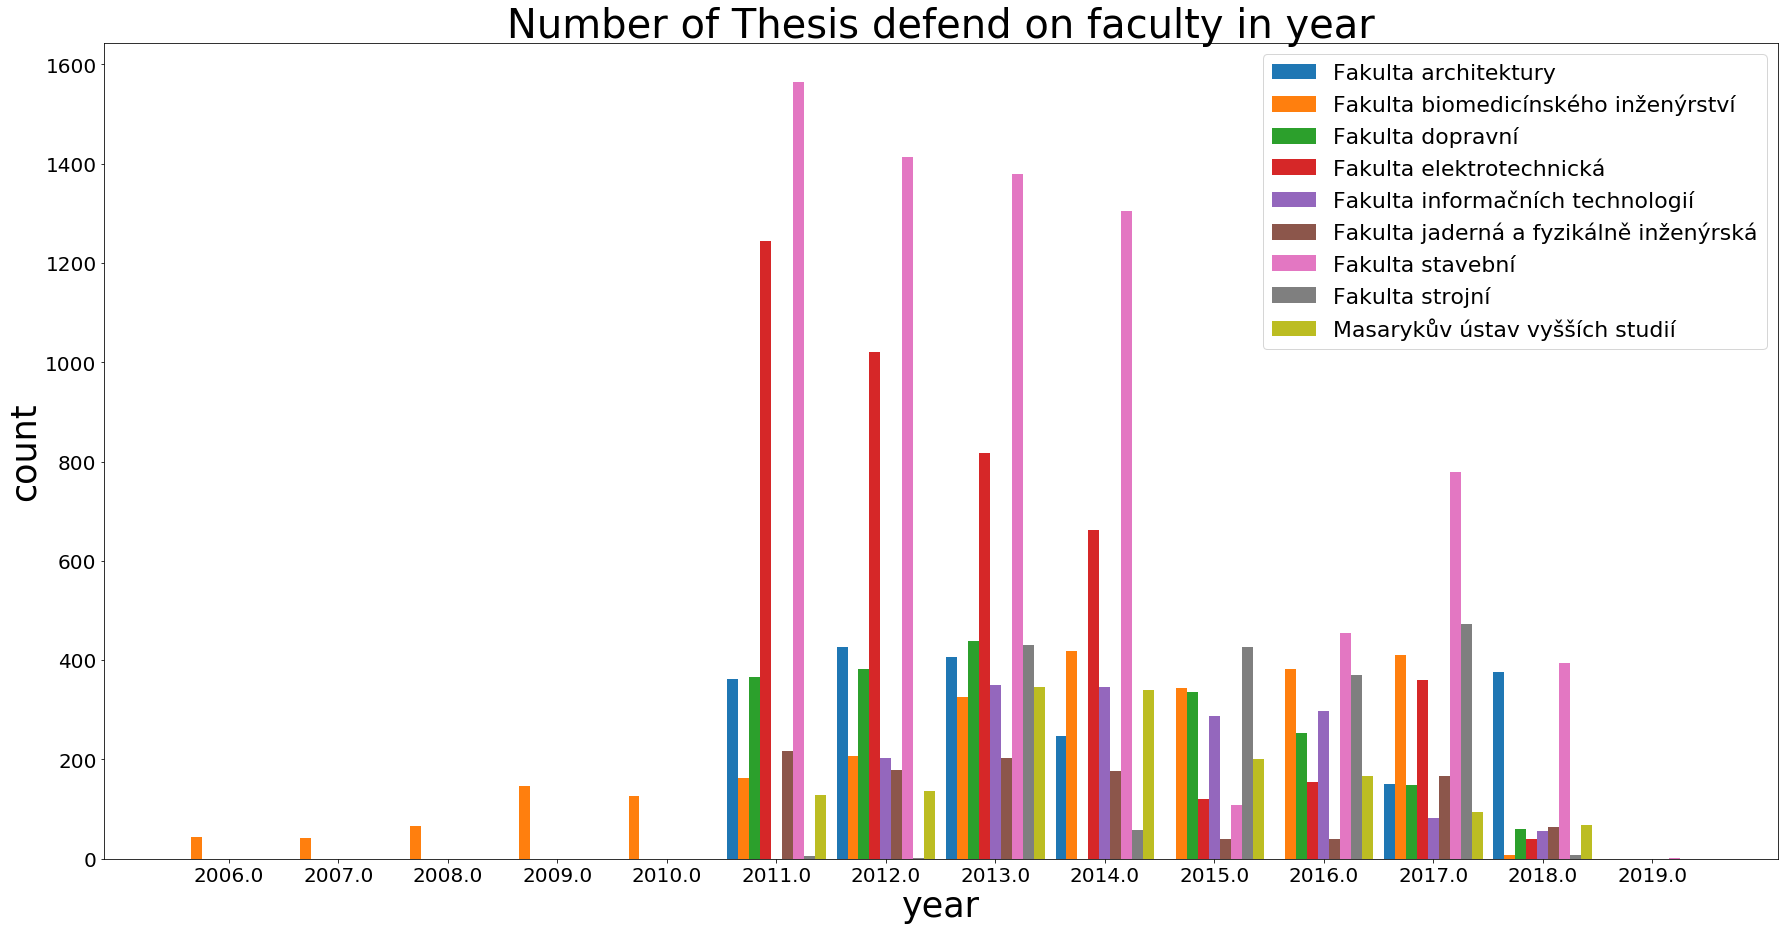

Only head of table for graph. It is too large. The table may be scaled up or exported to csv.

,year,faculty,count
64,2006.0,Fakulta biomedicínského inženýrství,43
65,2007.0,Fakulta biomedicínského inženýrství,42
59,2008.0,Fakulta biomedicínského inženýrství,67
50,2009.0,Fakulta biomedicínského inženýrství,146
53,2010.0,Fakulta biomedicínského inženýrství,127
23,2011.0,Fakulta dopravní,366
4,2011.0,Fakulta elektrotechnická,1245
37,2011.0,Fakulta jaderná a fyzikálně inženýrská,218
46,2011.0,Fakulta biomedicínského inženýrství,162
0,2011.0,Fakulta stavební,1564


The first graph shows that complete data has been found on the dspace site since 2011.

Data from previous years may be listed but, for example, they miss parameter

defend_date or the data are not listed at all. It is interesting to notice the

appearance of the defended works of our faculty in 2012.

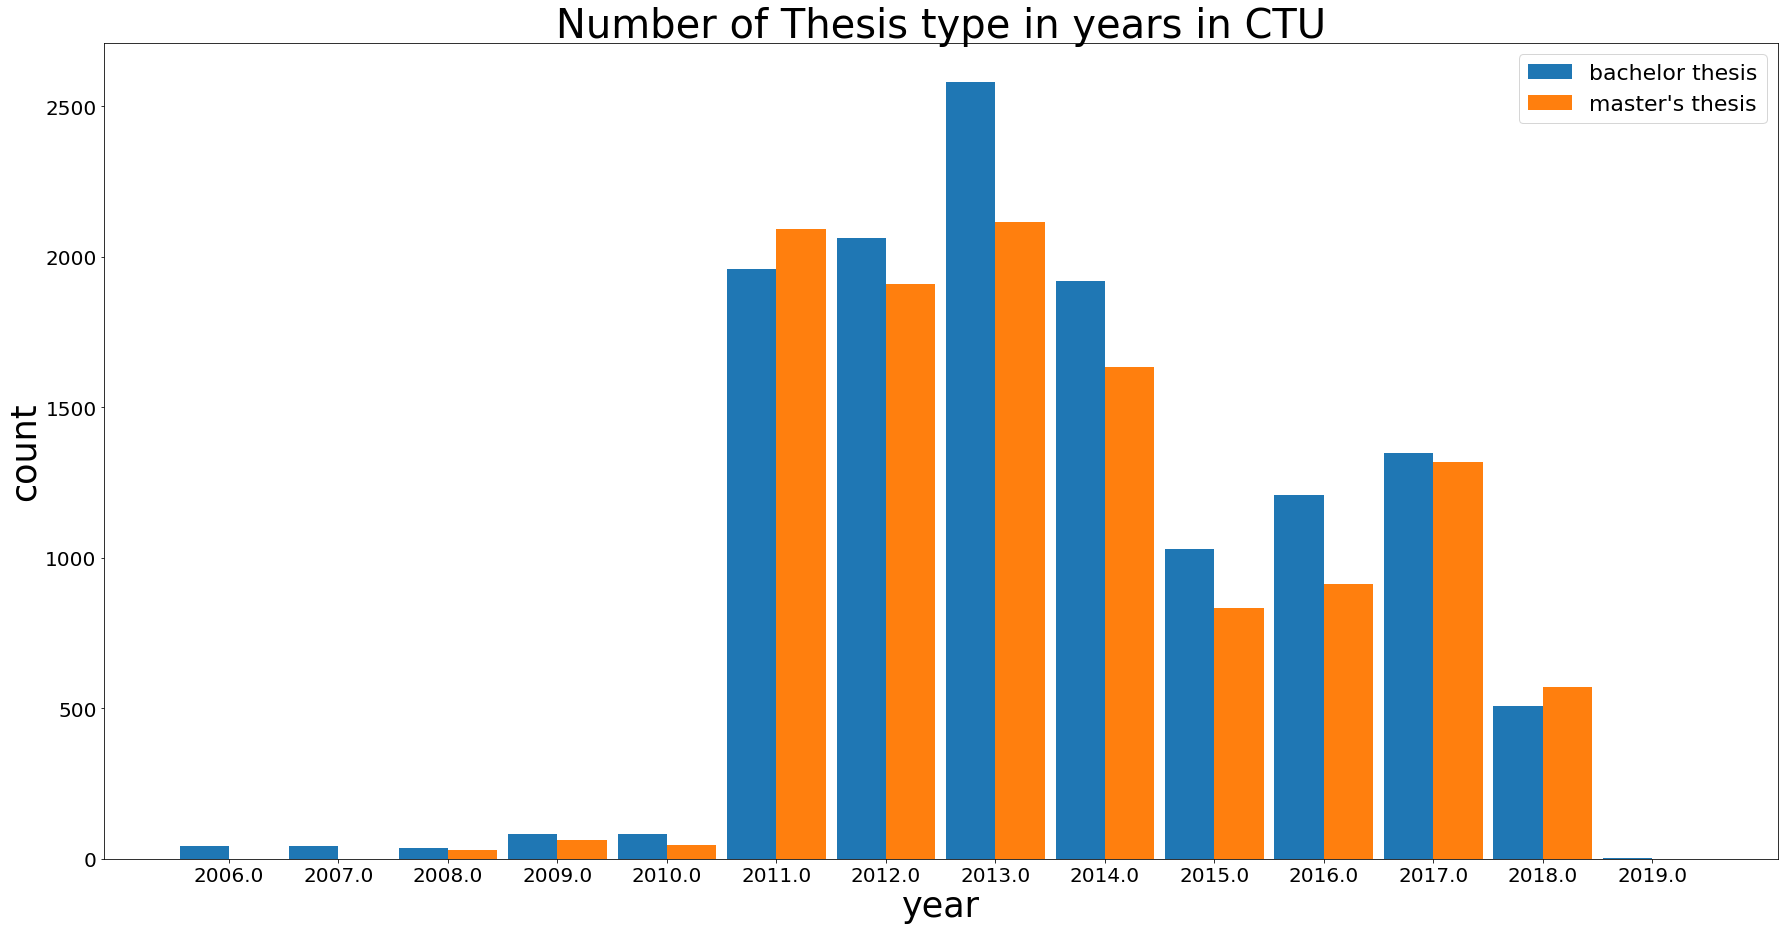

Only head of table for graph. It is too large. The table may be scaled up or exported to csv.

,year,type,count
20,2006.0,bachelor thesis,43
21,2007.0,bachelor thesis,42
22,2008.0,bachelor thesis,37
23,2008.0,master's thesis,30
16,2009.0,bachelor thesis,83
18,2009.0,master's thesis,63
17,2010.0,bachelor thesis,82
19,2010.0,master's thesis,45
4,2011.0,bachelor thesis,1959
2,2011.0,master's thesis,2092


#### Number of thesis defend on faculty, diveded into master and bachelor.

,faculty,type,count
9,Fakulta architektury,master's thesis,1096
11,Fakulta architektury,bachelor thesis,1014
4,Fakulta biomedicínského inženýrství,bachelor thesis,1662
10,Fakulta biomedicínského inženýrství,master's thesis,1035
12,Fakulta dopravní,bachelor thesis,1005
8,Fakulta dopravní,master's thesis,1152
3,Fakulta elektrotechnická,bachelor thesis,2724
2,Fakulta elektrotechnická,master's thesis,3135
5,Fakulta informačních technologií,bachelor thesis,1400
14,Fakulta informačních technologií,master's thesis,874


In [9]:
dataCVUT = RAW_DATA.copy()
#group by year and faculty

def groupedBoxPlot(boxLb, xLb, ttl):
    df1 = pd.DataFrame({'count' : dataCVUT.groupby([xLb, boxLb
                                    ]).size().sort_values(ascending=False)}).reset_index()
    
    #create subplots
    fig, ax = plt.subplots(figsize=(30,15))
    plt.ylabel("count", size = 35)
    plt.xlabel(xLb, size = 35)
    plt.rc('axes',labelsize=30, titlesize=30)
    #x 
    ind = sorted(df1[xLb].unique())
    #bar
    fac = sorted(df1[boxLb].unique())

    magicNumber = float(0.90/len(fac)) # the width of the bars
    startNumber = float(-1*(0.90/2)) #distribute bars near the year

    pp = []
    for f in fac:
        # Get data by faculty
        df = df1.loc[df1[boxLb] == f, [xLb, 'count']].sort_values(by = xLb, ascending=True)
        # Add year which are not in faculty. Fill with 0
        for yr in ind:
            if yr not in df[xLb].tolist():
                df = df.append(pd.DataFrame([[yr, 0]], columns=[xLb, 'count']), ignore_index=True)
        # List from sorted years with count
        df = df.sort_values(by = xLb, ascending=True)["count"].tolist()
        # Create bars shifted by number which distributed around the year
        pp.append(ax.bar([x+startNumber+magicNumber/2 for x in ind], df, magicNumber))
        startNumber += magicNumber

    ax.set_title(ttl, size = 40)
    ax.set_xticks([x for x in ind])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xticklabels(ind)
    
    ax.legend([x[0] for x in pp], fac, fontsize = 22)
    ax.autoscale_view()
    plt.show()
    display(Markdown("Only head of table for graph. It is too large. The table may be scaled up or exported to csv."))
    display(df1.sort_values(by=boxLb).sort_values(by=xLb).head(10))
    
groupedBoxPlot('faculty', 'year', 'Number of Thesis defend on faculty in year')
display(Markdown('The first graph shows that complete data has been found on the dspace site since 2011.'))
display(Markdown('Data from previous years may be listed but, for example, they miss parameter'))
display(Markdown('defend_date or the data are not listed at all. It is interesting to notice the'))
display(Markdown('appearance of the defended works of our faculty in 2012.'))

groupedBoxPlot('type', 'year', 'Number of Thesis type in years in CTU')
display(Markdown('#### Number of thesis defend on faculty, diveded into master and bachelor.'))
boxLb = 'type'
xLb = 'faculty'
df1 = pd.DataFrame({'count' : dataCVUT.groupby([xLb, boxLb]).size().sort_values(ascending=False)}).reset_index()
display(df1.sort_values(by=boxLb).sort_values(by=xLb))

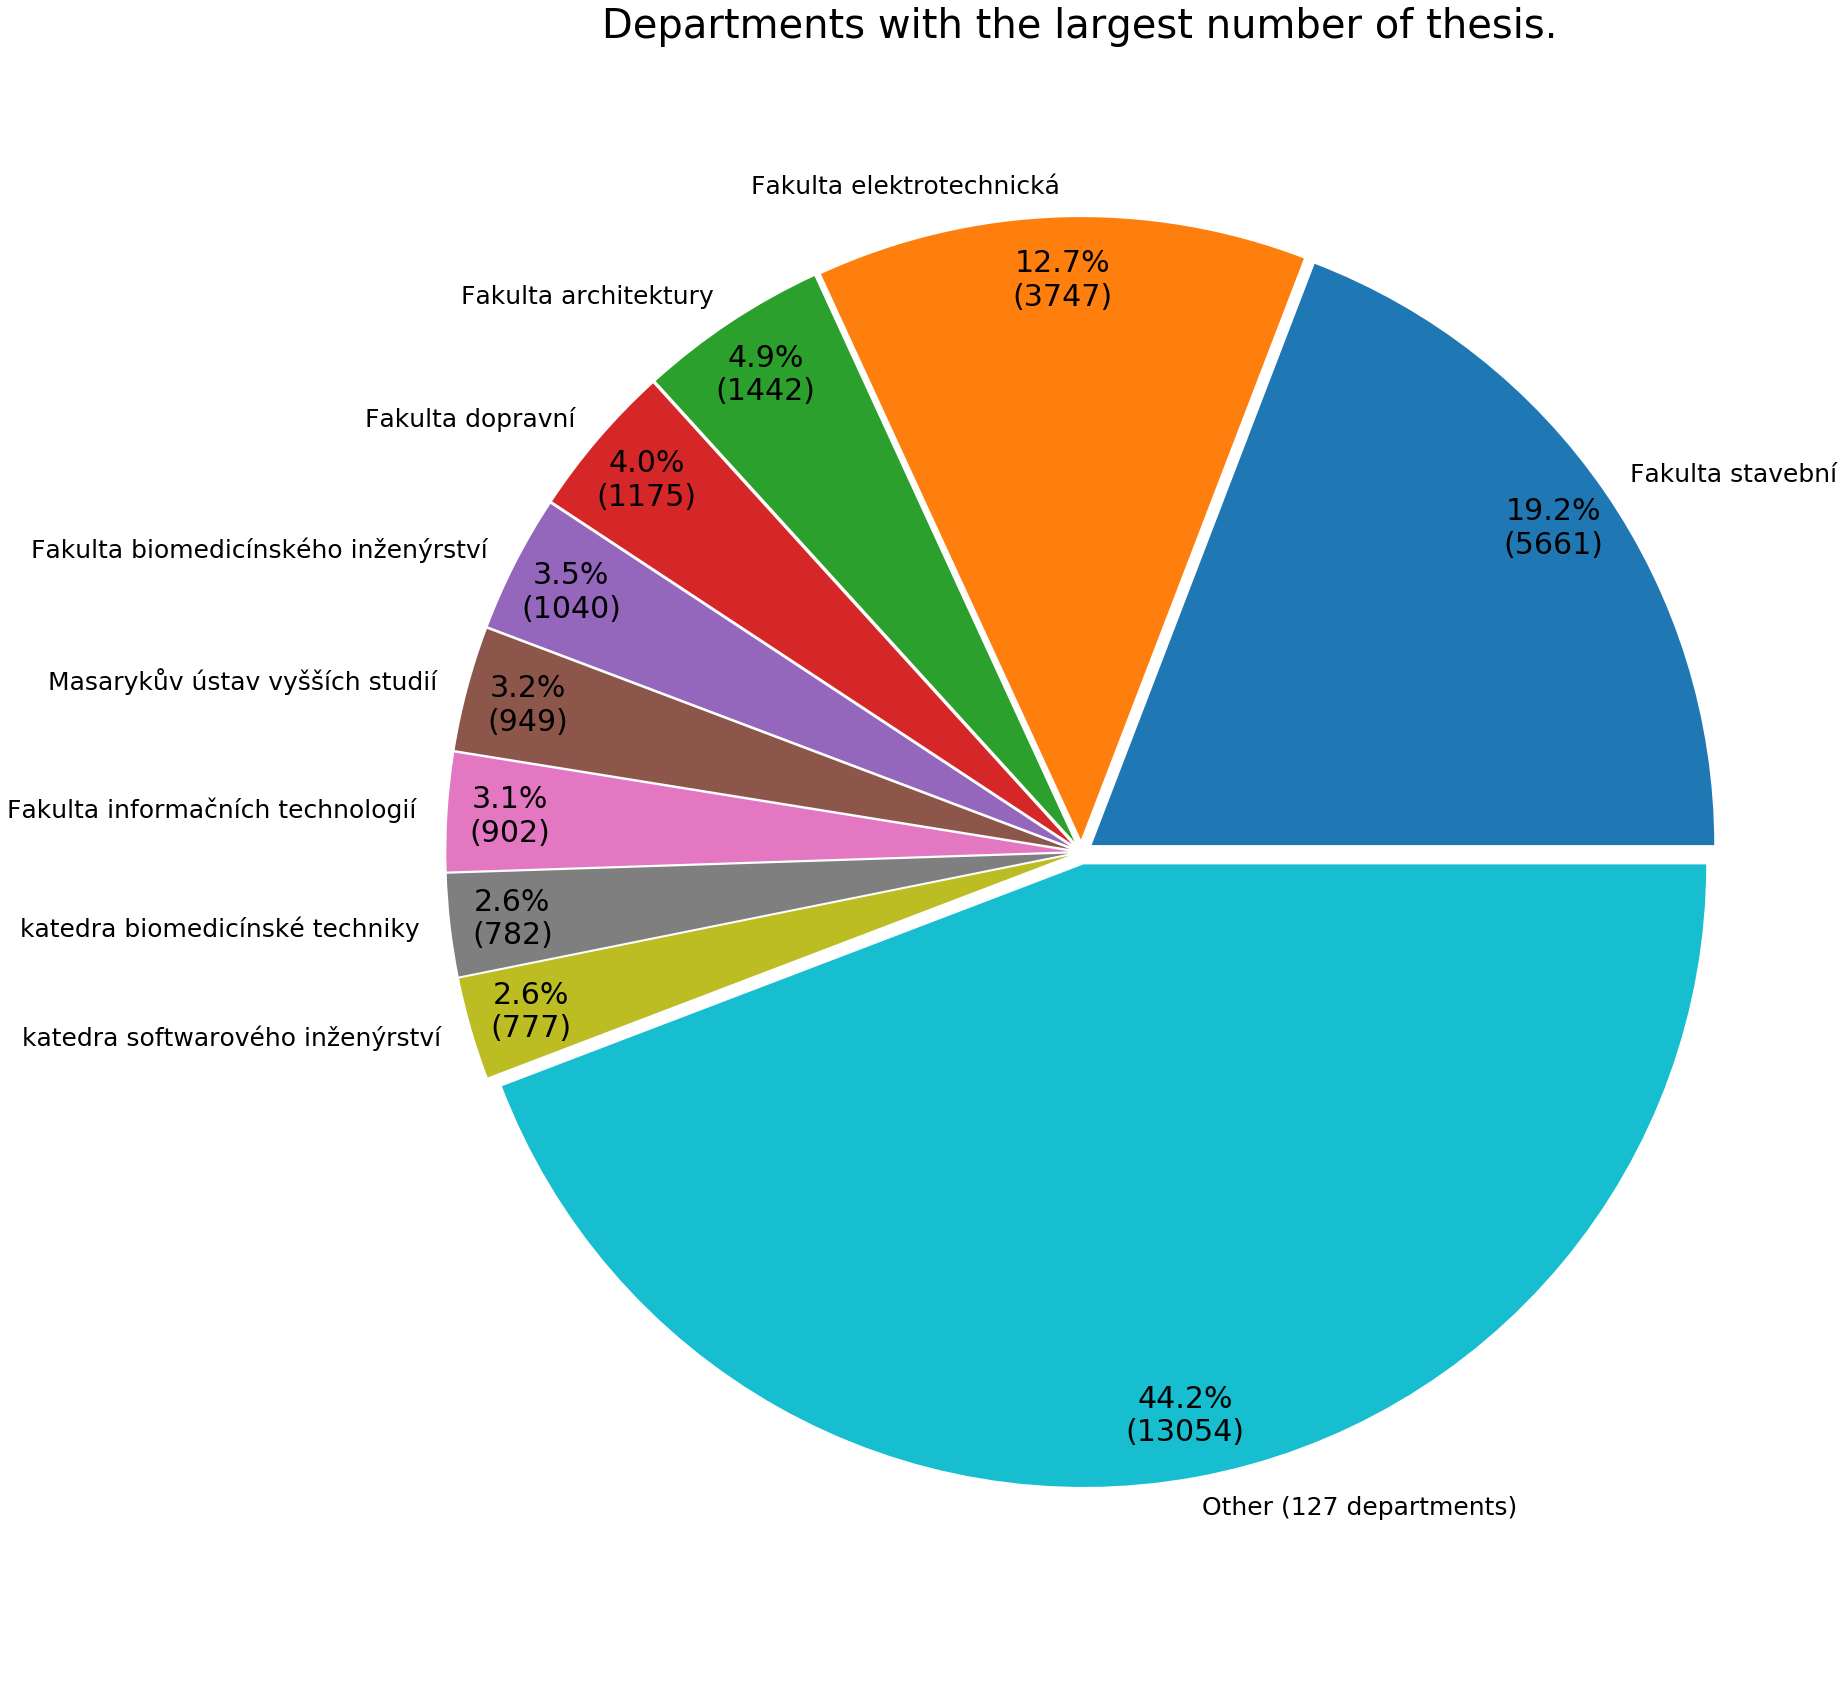

,department,count
0,Fakulta stavební,5662
1,Fakulta elektrotechnická,3747
2,Fakulta architektury,1443
3,Fakulta dopravní,1176
4,Fakulta biomedicínského inženýrství,1041
5,Masarykův ústav vyšších studií,949
6,Fakulta informačních technologií,902
7,katedra biomedicínské techniky,782
8,katedra softwarového inženýrství,778
0,Other (127 departments),13055


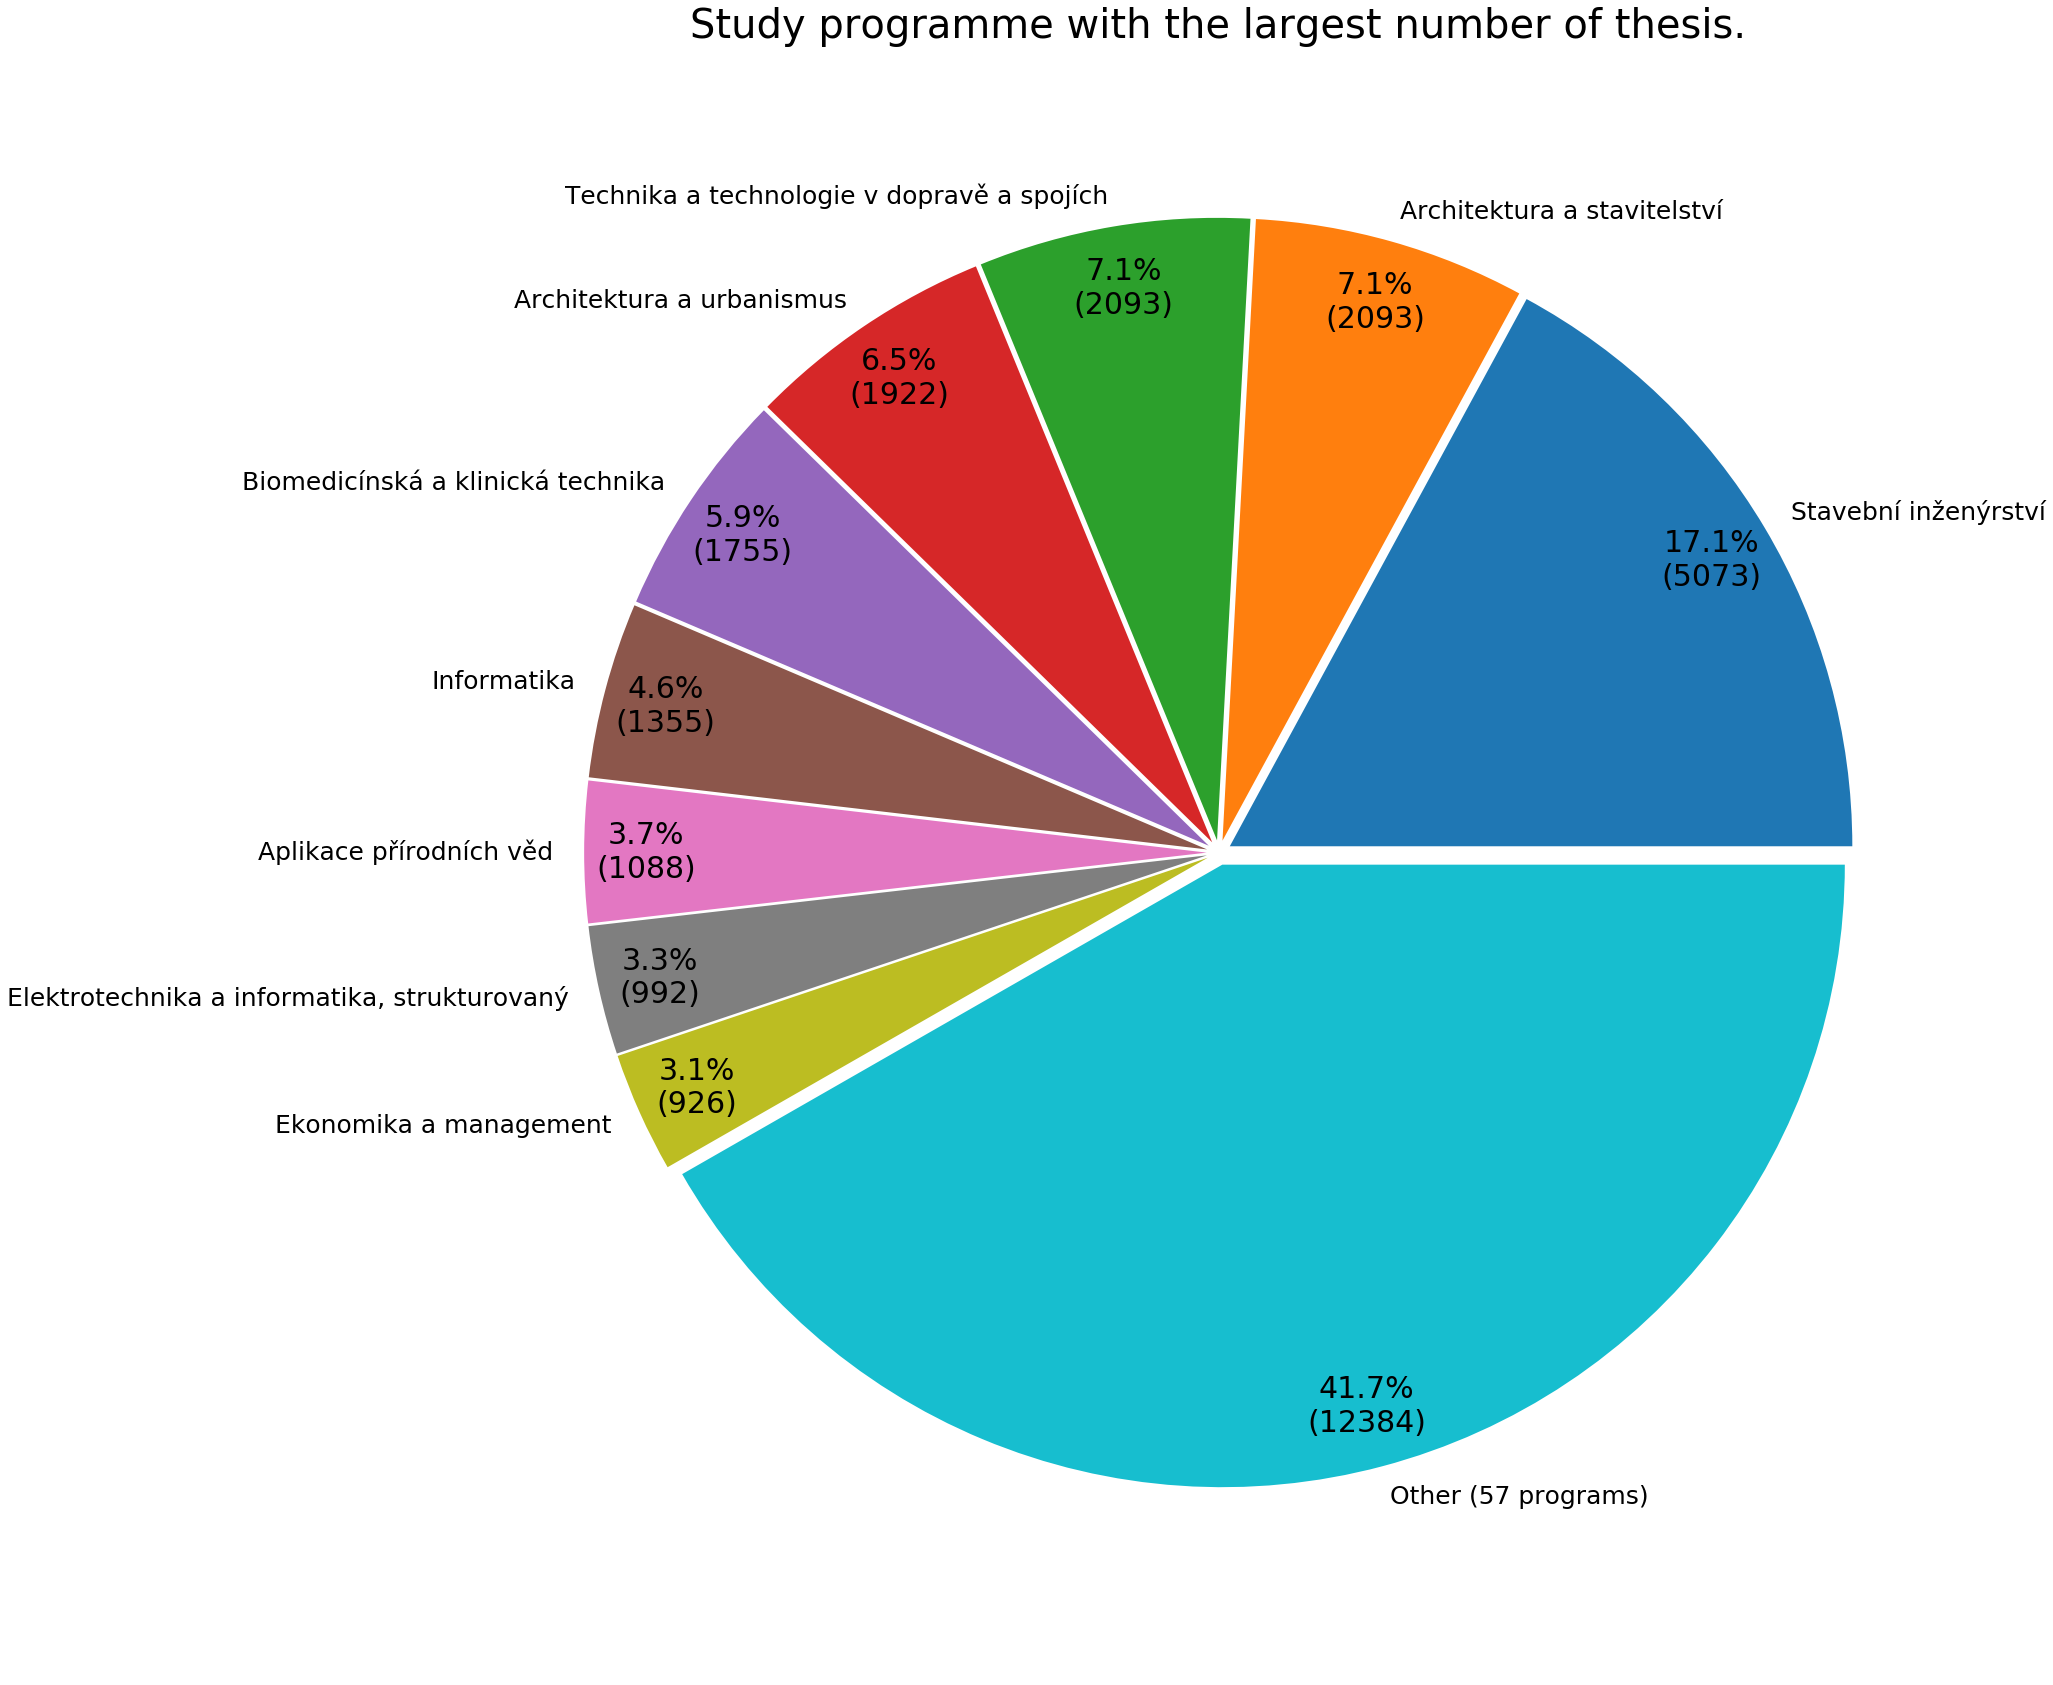

,programme,count
0,Stavební inženýrství,5073
1,Architektura a stavitelství,2094
2,Technika a technologie v dopravě a spojích,2093
3,Architektura a urbanismus,1922
4,Biomedicínská a klinická technika,1756
5,Informatika,1355
6,Aplikace přírodních věd,1088
7,"Elektrotechnika a informatika, strukturovaný",992
8,Ekonomika a management,927
0,Other (57 programs),12384


#### Supervisors programme with the largest number of thesis.

,supervisor,count,percent
0,Náplava Pavel,184,0.637782
1,Kuklíková Anna,129,0.44714
2,Svoboda Pavel,113,0.391681
3,Chludil Jiří,107,0.370884
4,Pospíchal Václav,107,0.370884
5,Šestáková Irena,103,0.357019
6,Šimeček Ivan,102,0.353553
7,Jandera Michal,98,0.339688
8,Knytl Luboš,94,0.325823
9,Lédl Petr,93,0.322357


#### Reviewers with the largest number of thesis.

,rewiever,count,percent
0,Kordík Pavel,86,0.405374
1,Šimeček Ivan,79,0.372378
2,Chludil Jiří,75,0.353523
3,Škorňová Eva,67,0.315814
4,Cupal Libor,65,0.306387
5,Valenta Michal,64,0.301673
6,Kubr Jan,60,0.282819
7,Krejčí Pavel,60,0.282819
8,Náhlík Josef,59,0.278105
9,Kudrna Valdemar,52,0.24511


In [30]:
dataCVUT = RAW_DATA.copy()

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def pieChart(sizes, labels, title, rotation):

    plt.rc('axes',labelsize=20, titlesize=30)
    fig1, ax1 = plt.subplots(figsize=(25,30))
    patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct=lambda pct: func(pct, sizes), 
        startangle=rotation, textprops={'fontsize': 30}, pctdistance=0.9, labeldistance=1.05, explode=len(sizes)*[0.02])
    for i in texts:
        i.set_fontsize(25)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(title, size = 40)

    plt.show()
    

def pieChartFromDataFrame(dataFrame, groupBy, otherName, numberOfPieces, title, rotation=0):
    dataFrame = pd.DataFrame({'count' : dataCVUT.groupby([groupBy]).size().sort_values(ascending=False)}).reset_index()
    tmp = dataFrame.loc[numberOfPieces:,:].sum()
    tmp[groupBy] = "Other (" + str(dataFrame.loc[:,:].count()['count']) + " " + otherName + ")"
    dataFrame = pd.concat([dataFrame.loc[:numberOfPieces,:],pd.DataFrame(tmp).transpose()], sort=False)

    labels = dataFrame[groupBy]
    sizes = dataFrame['count']

    explode = [0] * len(labels) 
    
    pieChart(sizes, labels,title, rotation )
    display(dataFrame)


pieChartFromDataFrame(dataCVUT, 'department', "departments", 8,
                      "Departments with the largest number of thesis.")


pieChartFromDataFrame(dataCVUT, 'programme', "programs", 8,
                      "Study programme with the largest number of thesis.")

numberOfPieces = 10
display(Markdown("#### Supervisors programme with the largest number of thesis."))

dataFrame = pd.DataFrame({'count' : dataCVUT.groupby(['supervisor']).size().sort_values(ascending=False)}).reset_index()
tmp = dataFrame.loc[numberOfPieces:,:].sum()
tmp['supervisor'] = "Other (" + str(dataFrame.loc[:,:].count()['count']) + " " + 'supervisors' + ")"
dataFrame = pd.concat([dataFrame.loc[:numberOfPieces,:],pd.DataFrame(tmp).transpose()], sort=False)
dataFrame['percent'] = (dataFrame['count'] / dataFrame['count'].sum())*100.
display(dataFrame)
display(Markdown("#### Reviewers with the largest number of thesis."))
dataFrame = pd.DataFrame({'count' : dataCVUT.groupby(['rewiever']).size().sort_values(ascending=False)}).reset_index()
tmp = dataFrame.loc[numberOfPieces:,:].sum()
tmp['rewiever'] = "Other (" + str(dataFrame.loc[:,:].count()['count']) + " " + 'reviewers' + ")"
dataFrame = pd.concat([dataFrame.loc[:numberOfPieces,:],pd.DataFrame(tmp).transpose()], sort=False)
dataFrame['percent'] = (dataFrame['count'] / dataFrame['count'].sum())*100.
display(dataFrame)


In [6]:
dataCVUT = RAW_DATA.copy()
df1 = pd.DataFrame({'count' : dataCVUT.groupby(['year', 'faculty'
                                ]).size().sort_values(ascending=False)}).reset_index()

years = sorted(df1['year'].unique())
facs = sorted(df1['faculty'].unique())
data = pd.DataFrame(columns = sorted(df1['faculty'].unique()))
for y in years:
    tmp = df1.loc[df1['year'] == y, ['faculty', 'count']].sort_values(by = 'faculty', ascending=True)
    tmp.index = tmp['faculty']
    tmp = tmp.drop('faculty', axis=1).transpose()
    tmp.index = [y]
    data = pd.concat([data,tmp], sort=False)
    
for f in facs:
    data[f]  = pd.to_numeric(data[f], errors='ignore')

display(Markdown('#### Mean/median(50%)/minimum/maximum number of supervised theses per year for faculties.'))
display(data.transpose().reindex(sorted(years), axis=1).describe().loc[['mean', '50%', 'min', 'max']])

#### Mean/median(50%)/minimum/maximum number of supervised theses per year for faculties.

,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
mean,43.0,42.0,67.0,146.0,127.0,506.375,441.111111,521.777778,444.5,232.625,265.125,296.333333,119.555556,1.0
50%,43.0,42.0,67.0,146.0,127.0,290.500,207.000000,406.000000,343.0,243.500,276.000,166.000000,61.000000,1.0
min,43.0,42.0,67.0,146.0,127.0,5.000,2.000000,203.000000,58.0,40.000,39.000,83.000000,7.000000,1.0
max,43.0,42.0,67.0,146.0,127.0,1564.000,1413.000000,1380.000000,1305.0,427.000,454.000,779.000000,395.000000,1.0


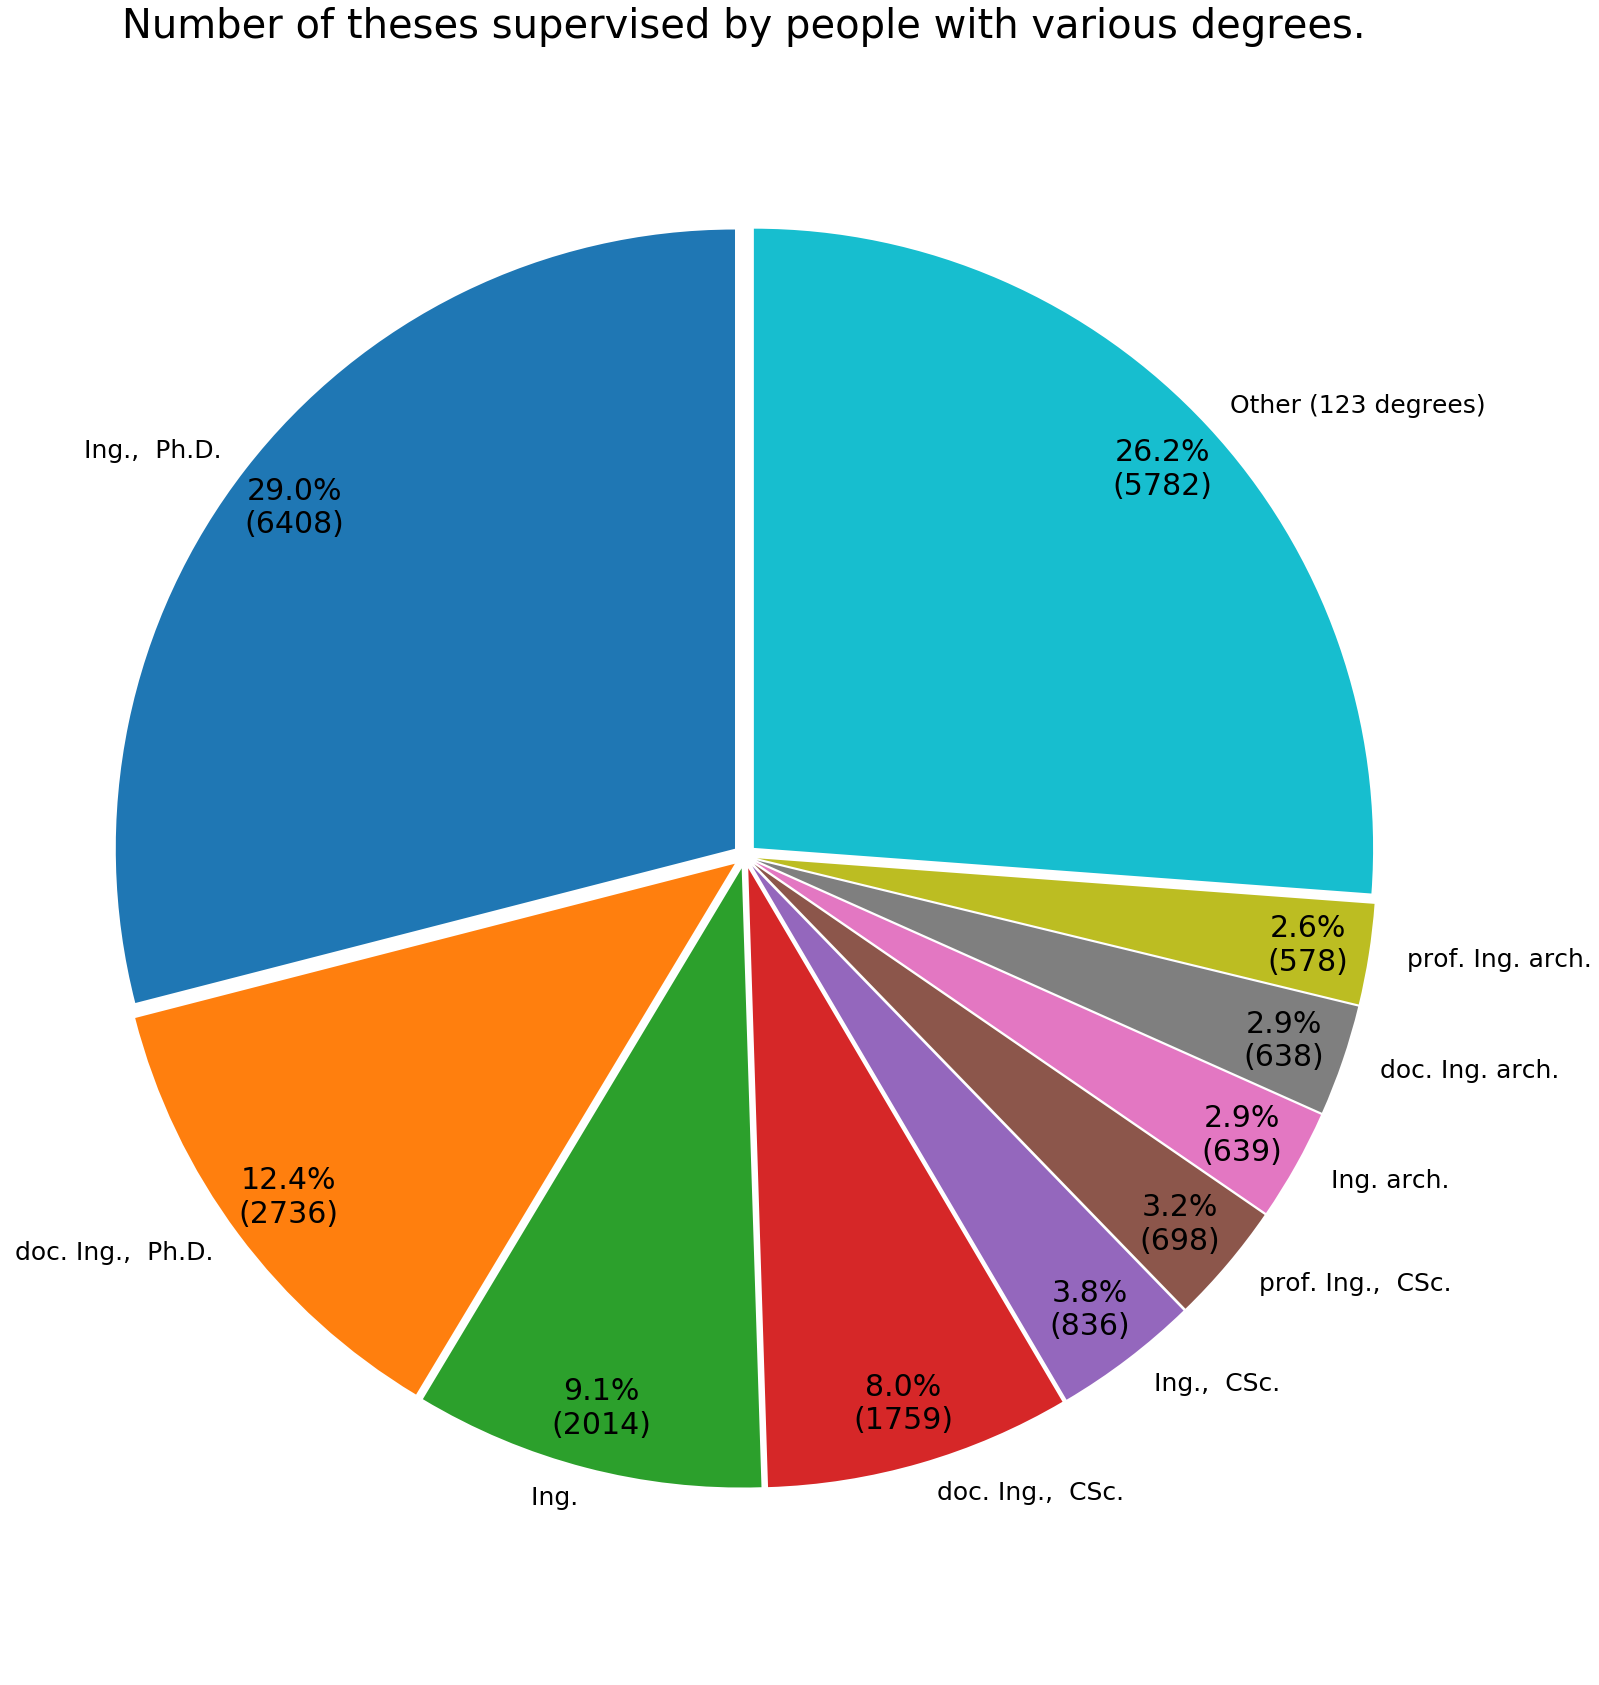

,supervisor_degree,count
0,"Ing., Ph.D.",6408
1,"doc. Ing., Ph.D.",2736
2,Ing.,2014
3,"doc. Ing., CSc.",1759
4,"Ing., CSc.",837
5,"prof. Ing., CSc.",698
6,Ing. arch.,640
7,doc. Ing. arch.,638
8,prof. Ing. arch.,579
0,Other (123 degrees),5782


In [31]:
dataCVUT = RAW_DATA.copy()


pieChartFromDataFrame(dataCVUT, 'supervisor_degree', "degrees", 8,
                      "Number of theses supervised by people with various degrees.", 90)
